# Baselines for SciFact and Citation-Integrity

This notebook shows baselines for claim verification on two datasets (SciFact and Citation-Integrity) using training checkpoints from the MultiVerS project.

- The training steps are described in [the MultiVerS paper](10.48550/arXiv.2112.01640) and in [training.md](../doc/training.md).
- Pre-training in MultiVerS is performed on the Fever, EvidenceInference and PubmedQA datasets with shuffled data to produce the `fever_sci` checkpoint.
- Fine-tuning is done on the specific target dataset to produce the corresponding checkpoints:
    - COVIDFact (`covidfact`)
    - HealthVer (`healthver`)
    - SciFact (`scifact`)
- The Citation-Integrity study provides a best model (file name: `bestModel-001`) that is labeled here as the `citint` checkpoint.
    - Predictions with this checkpoint are made using code in the `model/multivers-citint` directory because of added tokens for citation markers.

Start by importing the necessary packages including the `eval` package from this repo for reading the data and predictions and calculating metrics:

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Get the current directory and parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Import eval from the parent directory
import eval

Calculate F1 scores for each combination of checkpoint, dataset, and fold.

In [2]:
# List checkpoints and datasets
datasets = ['scifact', 'scifact', 'citint', 'citint', 'citint']
folds = ['train', 'dev', 'train', 'dev', 'test']
checkpoints = ['fever_sci', 'covidfact', 'healthver', 'scifact', 'citint']
# Get DataFrame of F1 scores
df = eval.get_metric(datasets, folds, checkpoints, 'f1')

Round numeric values and print the first five rows.

In [3]:
df.round(2).head()

,metric,dataset,fold,checkpoint,SUPPORT,REFUTE,NEI,micro,macro
0,f1,scifact,train,fever_sci,0.73,0.39,0.76,0.69,0.63
1,f1,scifact,dev,fever_sci,0.74,0.36,0.75,0.69,0.62
2,f1,citint,train,fever_sci,0.56,0.02,0.17,0.34,0.25
3,f1,citint,dev,fever_sci,0.58,0.00,0.22,0.36,0.27
4,f1,citint,test,fever_sci,0.55,0.02,0.22,0.35,0.26


These are the F1 scores for predictions made with the `fever_sci` checkpoint.
Let's use the validation (dev) fold in each dataset to visualize the trends for all checkpoints.

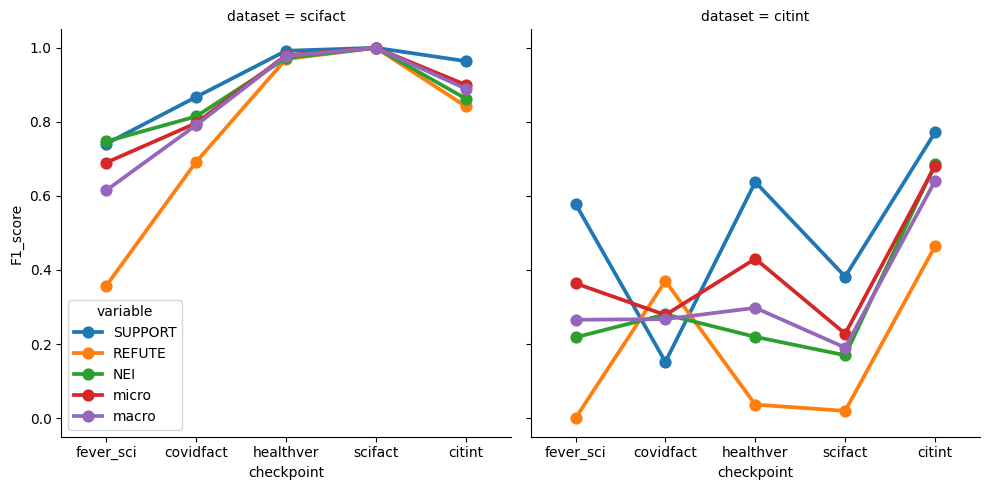

In [4]:
filtered_df = df[df['fold'] == 'dev']
df2 = pd.melt(filtered_df, id_vars=['metric', 'dataset', 'fold', 'checkpoint'], value_name = 'F1_score')
plot_ = sns.catplot(data=df2, col='dataset', x='checkpoint', y='F1_score', hue='variable', kind='point', legend_out=False)

As expected, the best predictions for each dataset come from the respective checkpoint that was fine-tuned on that dataset.
The `scifact` checkpoint shows exceptionally high performance on the SciFact dataset, but only on training and dev folds.

In [5]:
df[(df['dataset'] == 'scifact') & (df['checkpoint'] == 'scifact')]

,metric,dataset,fold,checkpoint,SUPPORT,REFUTE,NEI,micro,macro
15,f1,scifact,train,scifact,1.0,1.0,1.0,1.0,1.0
16,f1,scifact,dev,scifact,1.0,1.0,1.0,1.0,1.0


Among the pretraining checkpoints used for predictions on Citation-Integrity, `covidfact` produces the highest F1 score for REFUTE, but the lowest score for SUPPORT.
On the other hand, `healthver` shows the highest micro and macro F1 and good performance for all labels except REFUTE.
The differences are likely related to the [high number of COVID-related statements](http://localhost:8888/notebooks/05_Data-Exploration-for-Citation-Integrity.ipynb#Wordcloud) in Citation-Integrity.

**Actions**
- Consider using the `covidfact` checkpoint for fine-tuning on the Citation-Integrity dataset (the authors of the study fine-tuned starting from the `healthver` checkpoint).
- Investigate whether the lower accuracy of predictions for Citation-Integrity than SciFact is due to claim complexity, model hyperparameters, or some other factor.

## A little data cleaning

Here we compare the original `citint` with the dataset with no citation markers in the claims (`citintnm`).
Predictions are made from the HealthVer pre-training checkpoint and the “best” model from the Citation-Integrity study (`checkpoint = citint`).
The x-axis represents `p`recision and `r`ecall for each of the labels.

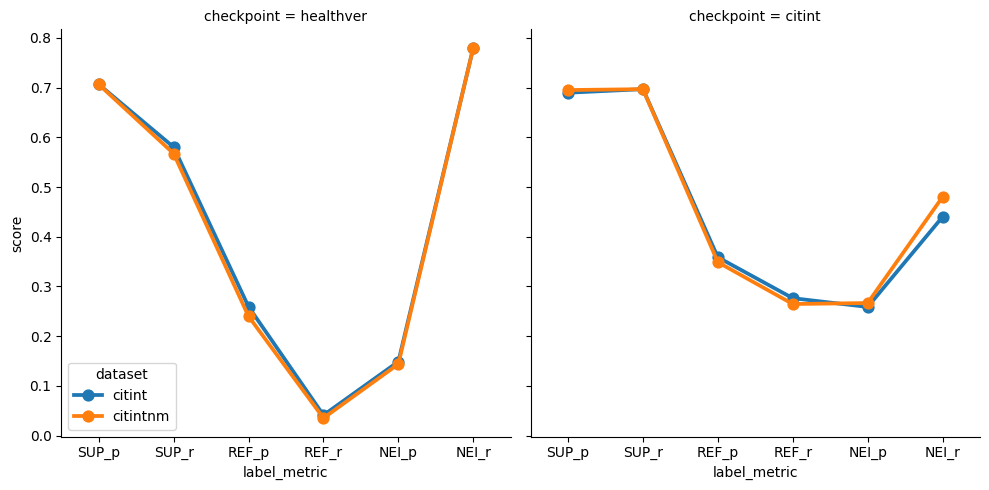

In [6]:
# Define datasets and checkpoints
datasets = ['citint', 'citintnm']
folds = ['test', 'test']
checkpoints = ['healthver', 'citint']
precision_df = eval.get_metric(datasets, folds, checkpoints, 'precision')
precision_df.drop(columns = ['micro', 'macro'], inplace=True)
recall_df = eval.get_metric(datasets, folds, checkpoints, 'recall')
recall_df.drop(columns = ['micro', 'macro'], inplace=True)

# Combine precision and recall values
df = pd.concat([precision_df, recall_df])
df2 = pd.melt(df, id_vars=['metric', 'dataset', 'fold', 'checkpoint'], var_name = 'label', value_name = 'score')
# Abbreviate labels and add _p or _r
df2['label_metric'] = df2['label'].str[:3]+'_'+df2['metric'].str[0]
plot_ = sns.catplot(data=df2, col='checkpoint', x='label_metric', y='score', hue='dataset', kind='point', legend_out=False)

Most of the differences are fairly small, but removing the citation markers results in better recall for NEI for the “best” model.

(3.999, 16.0]    64
(16.0, 20.0]     76
(20.0, 22.0]     51
(22.0, 25.0]     62
(25.0, 28.0]     62
(28.0, 31.0]     54
(31.0, 36.0]     66
(36.0, 42.0]     59
(42.0, 52.0]     53
(52.0, 262.0]    59
Name: count, dtype: int64


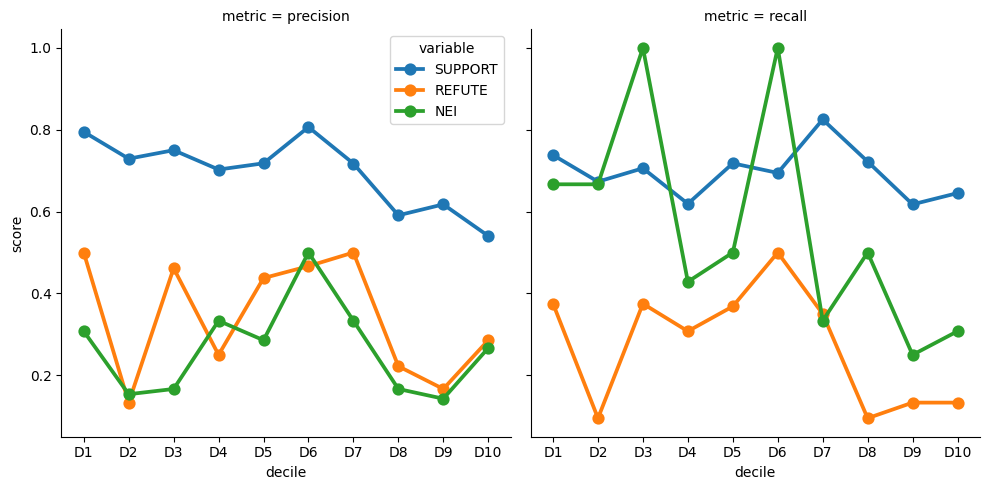

In [7]:
# Define datasets and checkpoints
datasets = ['citintnm']
folds = ['test']
checkpoints = ['citint']

# Run the function once to print the ranges of word lengths and value counts
qcut = eval.get_metric(datasets, folds, checkpoints, 'precision', 'D1', return_qcut = True)
print(qcut.value_counts()[qcut.cat.categories])

df = pd.DataFrame()
deciles = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']
for decile in deciles:
    precision_df = eval.get_metric(datasets, folds, checkpoints, 'precision', decile)
    precision_df['decile'] = decile
    precision_df.drop(columns = ['micro', 'macro'], inplace=True)
    recall_df = eval.get_metric(datasets, folds, checkpoints, 'recall', decile)
    recall_df['decile'] = decile
    recall_df.drop(columns = ['micro', 'macro'], inplace=True)
    df = pd.concat([df, precision_df, recall_df], ignore_index = True)

df2 = pd.melt(df, id_vars=['metric', 'dataset', 'fold', 'checkpoint', 'decile'], value_name = 'score')
plot_ = sns.catplot(data=df2, col='metric', x='decile', y='score', hue='variable', kind='point', legend_out=False)

Scores are generally lower for the longest claims, but the effect is strongest for precision of SUPPORT and recall of NEI.

**Action**
- Rewriting claims to 30 words or less is one approach to improving performance.
- Perfect recall of NEI for some word count ranges should be investigated as it may relate to replicated claims or evidence.
    - Note that predictions on the `dev` fold have perfect recall for NEI for the whole dataset.